In [17]:
import pandas as pd
import json
import math
import hashlib
import numpy as np
import os
import matplotlib.pyplot as plt
from pandas import json_normalize
from glob import glob
from datetime import datetime, date
from math import radians, cos, sin, asin, sqrt
from scipy.stats import kde

In [133]:
# Koelner Dom coordinates
obs_lat = 50.941520367
obs_lon = 6.957295594

# AREO Turm
obs_lat = 50.911700
obs_lon = 6.963006

# Colonius
obs_lat = 50.946944444
obs_lon = 6.931944444



In [134]:
min_alt = (47 + 55 + 157) / 0.3048 # Dom

min_alt = (47 + 51 + 76) / 0.3048 # AREO Turm

min_alt = (47 + 48 + 268) / 0.3048 # Colonius

In [98]:
limit_H = 2000
limit_V = 1000

In [135]:
data_path = './data_baseline/'
gdf_input_files = glob(data_path + 'gdf*.json')
gdf = pd.concat([pd.read_json(file, lines=False) for file in gdf_input_files])
gdf = gdf.reset_index(drop = True)
gdf['date'] = gdf.time.apply(lambda x: datetime.fromtimestamp(int(x)))

In [136]:
gdf.shape

(193799, 24)

In [31]:
def bounding_box(lat, lon, half_dist_m=600):
    # Calculate latitudinal and longitudinal offsets in degrees
    lat_offset = (half_dist_m / 111120)  # 1 degree of latitude is approximately 111.32 km
    lon_offset = (half_dist_m / (111120 * abs(cos(radians(lat)))))  # 1 degree of longitude varies with latitude

    # Calculate the limits of the bounding box
    lat_min = lat - lat_offset
    lat_max = lat + lat_offset
    lon_min = lon - lon_offset
    lon_max = lon + lon_offset

    return lat_min, lat_max, lon_min, lon_max

In [137]:
lat_min, lat_max, lon_min, lon_max = bounding_box(obs_lat, obs_lon, 600)

In [14]:
# Bounding box around Koelner Dom obstacle, containing the 600 m clearance radius

#lat_min, lat_max = 50.935835, 50.947068
#lon_min, lon_max = 6.948488, 6.966398

In [138]:
gdf = gdf.loc[(gdf.lat >= lat_min) & (gdf.lat <= lat_max) & (gdf.lon >= lon_min) & (gdf.lon <= lon_max)]

In [139]:
gdf.shape

(5038, 24)

In [37]:
def haversine(pt1, pt2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    Returned units are in metres. Differs slightly from PostGIS geography
    distance, which uses a spheroid, rather than a sphere.
    """

    lat1, lon1 = pt1[0], pt1[1]
    lat2, lon2 = pt2[0], pt2[1]

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2.0) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2.0) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371000  # Radius of earth in m
    return c * r

In [140]:
gdf['lateral_standoff'] = gdf.apply(lambda x: haversine((obs_lat, obs_lon), (x.lat, x.lon)) / 0.3048, axis = 1)

In [141]:
gdf['vertical_standoff'] = gdf.apply(lambda x: x.geoaltitude/0.3048 - min_alt, axis = 1)

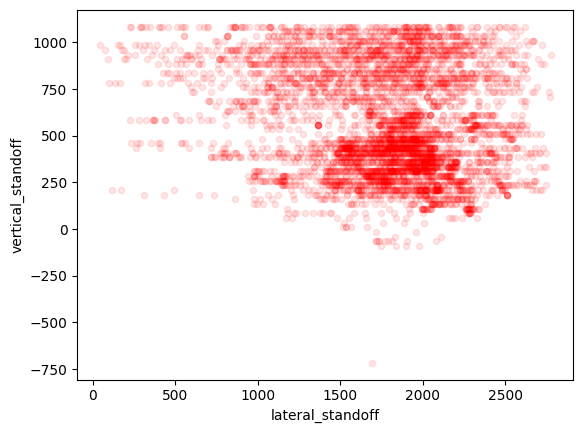

In [142]:
ax1 = gdf.plot(kind='scatter', x='lateral_standoff', y='vertical_standoff', color='r', alpha = 0.1)

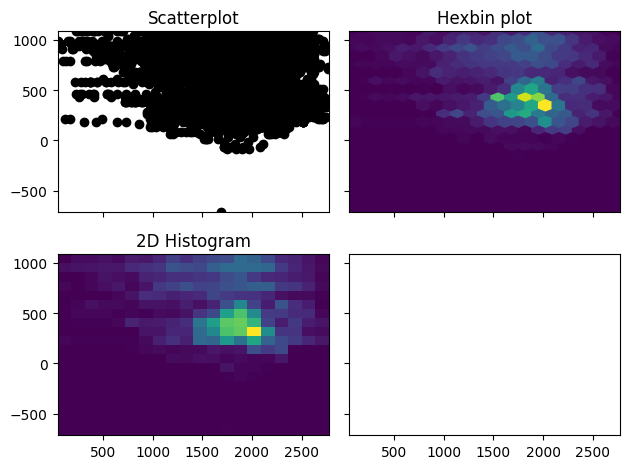

In [143]:
x = gdf.lateral_standoff
y = gdf.vertical_standoff

nbins = 20

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)

axes[0, 0].set_title('Scatterplot')
axes[0, 0].plot(x, y, 'ko')

axes[0, 1].set_title('Hexbin plot')
axes[0, 1].hexbin(x, y, gridsize=nbins)

axes[1, 0].set_title('2D Histogram')
axes[1, 0].hist2d(x, y, bins=nbins)

fig.tight_layout()
plt.show()

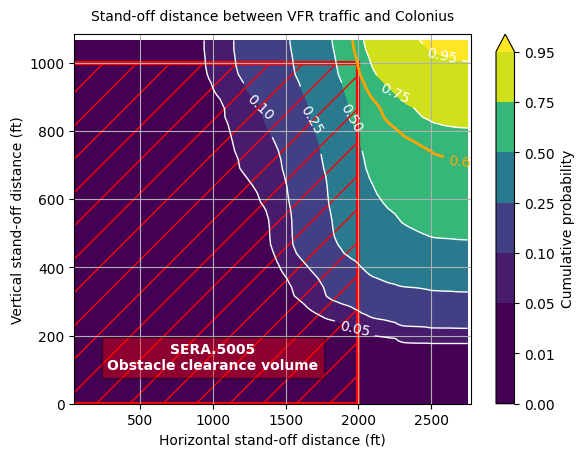

In [145]:
from matplotlib.colors import ListedColormap

# Assuming the DataFrame is named df with columns hmd_ft and vmd_ft
maxHso_ft = gdf['lateral_standoff'].max()
maxVso_ft = gdf['vertical_standoff'].max()

# Calculate bin centers
edgesX_ft = np.arange(0, maxHso_ft + 25, 25)
edgesY_ft = np.arange(-maxVso_ft, maxVso_ft + 25, 25)
centersX_ft = edgesX_ft[:-1] + np.diff(edgesX_ft) / 2
centersY_ft = edgesY_ft[:-1] + np.diff(edgesY_ft) / 2

# 2D Histogram
hist, xedges, yedges = np.histogram2d(gdf['lateral_standoff'], gdf['vertical_standoff'], bins=(centersX_ft, centersY_ft), density=False)

# Normalize the histogram to create CDF
cdf = hist.cumsum(axis=0).cumsum(axis=1) / hist.sum()

# Calculate bin centers using output of np.histogram2d
Xcenters = xedges[:-1] + np.diff(xedges) / 2
Ycenters = yedges[:-1] + np.diff(yedges) / 2

# Plot CDF contour
fig, ax = plt.subplots()
c_levels = [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.95]
c2_levels = [0.05, 0.1, 0.25, 0.5, 0.75, 0.95]
c_map = ListedColormap(plt.get_cmap('viridis')(np.linspace(0, 1, 20+len(c_levels))))
CS = ax.contourf(Xcenters, Ycenters, cdf.T, levels=c_levels, cmap=c_map, extend='max')
cbar = fig.colorbar(CS, ticks=c_levels, boundaries=np.linspace(0, 1, len(c_levels) + 1))
cbar.ax.set_ylabel('Cumulative probability')

# Add contour lines with labels
CS_lines = ax.contour(Xcenters, Ycenters, cdf.T, levels=c2_levels, colors='white', linewidths=1)
ax.clabel(CS_lines, inline=True, fontsize=10, colors='white', fmt='%.2f')

## Add the contour line with a 0.5 probability and set its color
# Find the bins within the rectangle
x_bins_in_rectangle = np.where((xedges[:-1] >= 0) & (xedges[:-1] <= limit_H))[0]
y_bins_in_rectangle = np.where((yedges[:-1] >= 0) & (yedges[:-1] <= limit_V))[0]
# Sum the counts in the bins within the rectangle and normalize by the total number of points
rectangle_count = hist[np.ix_(x_bins_in_rectangle, y_bins_in_rectangle)].sum()
probability_in_rectangle = rectangle_count / hist.sum()
# Add the contour line
CS_05_line = ax.contour(Xcenters, Ycenters, cdf.T, levels=[probability_in_rectangle], colors='orange', linewidths=2)
ax.clabel(CS_05_line, inline=True, fontsize=10, colors='orange', fmt='%.2f')

# Axes labels and grid
ax.set_xlabel('Horizontal stand-off distance (ft)')
ax.set_ylabel('Vertical stand-off distance (ft)')
ax.grid(True)
ax.set_xlim(50, maxHso_ft)
ax.set_ylim(0, maxVso_ft)

rectangle = plt.Rectangle((0, 0), limit_H, limit_V, linewidth=3, edgecolor='red', facecolor='none', hatch='/', label = 'Stay well-clear volume (SERA.5005)')
ax.add_patch(rectangle)
plt.text(1000, 100,'SERA.5005\nObstacle clearance volume', color='white', horizontalalignment='center', weight='bold', bbox=dict(facecolor='red', alpha=0.4, edgecolor='black'))

plt.title('Stand-off distance between VFR traffic and Colonius', fontsize=10, pad=10)

plt.show()


In [56]:
maxHso_ft

2766.19254654886

In [58]:
# Find the bins within the rectangle
x_bins_in_rectangle = np.where((xedges[:-1] >= 0) & (xedges[:-1] <= 2000))[0]
y_bins_in_rectangle = np.where((yedges[:-1] >= 0) & (yedges[:-1] <= 1000))[0]

# Sum the counts in the bins within the rectangle and normalize by the total number of points
rectangle_count = hist[np.ix_(x_bins_in_rectangle, y_bins_in_rectangle)].sum()
probability_in_rectangle = rectangle_count / hist.sum()

print(f"Probability of a point within the rectangle: {probability_in_rectangle:.4f}")

Probability of a point within the rectangle: 0.4191
